HMM-DDM: Mouse Data
========================
In this notebook we will analyse a dataset of mice performing a two-alternative forced choice (TAFC) task developed in Kane, Senne, and Scott, 2025. mice performed this task daily in two-hour periods.

In [1]:
using HiddenMarkovModels
using DriftDiffusionModels
using Plots
using CSV
using DataFrames
using Dates
using Random
using Distributions
using LinearAlgebra
using StatsBase
using JLD2
using Printf
using StatsPlots

## Load and Preprocess the data

In [2]:
function load_mouse_data(df::DataFrame, mouse_name::String15)
    mouse_df = df[df.name .== mouse_name, :]
    valid_trials = findall(outcome -> outcome != "omission", mouse_df.outcome)
    # drop all tirals less that 0.2 seconds
    valid_trials = findall(rt -> rt > 0.2, mouse_df.rt)
    filtered_df = mouse_df[valid_trials, :]
    numeric_outcomes = [outcome == "correct" ? 1 : -1 for outcome in filtered_df.outcome]
    valid_rt_indices = findall(rt -> uppercase(string(rt)) != "NAN", filtered_df.rt)
    final_df = filtered_df[valid_rt_indices, :]
    final_outcomes = numeric_outcomes[valid_rt_indices]
    final_rts = final_df.rt
    dates = [Date(split(dt)[1]) for dt in final_df.trial_datetime]
    return final_df, final_rts, final_outcomes, dates
end

function build_results_by_date(rts::Vector, outcomes::Vector, dates::Vector{Date})
    unique_dates = sort(unique(dates))
    results_by_date = Vector{Vector{DDMResult}}()
    for date in unique_dates
        idx = findall(dates .== date)
        if !isempty(idx)
            day_rts = rts[idx]
            day_outcomes = outcomes[idx]
            day_results = [DDMResult(rt, choice) for (rt, choice) in zip(day_rts, day_outcomes)]
            push!(results_by_date, day_results)
        end
    end
    return results_by_date
end

function AIC(model::PriorHMM, data::Vector{DDMResult}, seq_ends::Vector{Int})
    K = size(model.trans, 1)  # number of states

    # HMM parameter count:
    # - initial state (K-1 independent)
    # - transition matrix (K * (K - 1) independent)
    # - emission parameters: 3 per DDM state
    n_params = (K - 1) + K * (K - 1) + K * 3

    _, lls = forward(model, data; seq_ends=seq_ends)
    ll = sum(lls)

    return 2 * n_params - 2 * ll
end

function BIC(model::PriorHMM, data::Vector{DDMResult}, seq_ends::Vector{Int})
    K = size(model.trans, 1)

    n_params = (K - 1) + K * (K - 1) + K * 3

    _, lls = forward(model, data; seq_ends=seq_ends)
    ll = sum(lls)

    N = length(data)  # number of observations (trials)

    return log(N) * n_params - 2 * ll
end

BIC (generic function with 1 method)

In [3]:
ddir = "../data/mouse_df.csv"
# load in the data
df = CSV.File(ddir) |> DataFrame;

# get mouse names sorted by trials
mouse_names = sort(unique(df.name))
mouse_names = mouse_names[sortperm([length(findall(df.name .== name)) for name in mouse_names])]
mouse_names = mouse_names[end-2:end]  # limit to first 3 for testing

3-element Vector{String15}:
 "MTRAP-2"
 "FTRAP-7"
 "MABL6-9"

## Fit model and choose best 

In [ ]:
ddm_1_guess = DriftDiffusionModel(2.5, 0.5, 0.5, 0.5, 1)
ddm_2_guess = DriftDiffusionModel(1.5, 0.8, 0.5, 0.2, 1)
ddm_3_guess = DriftDiffusionModel(1.0, 1.0, 0.5, 0.2, 1)

function generate_hmm(n_states::Int)
    if n_states == 1
        init = [1.0]
        trans = [1.0;;]  # or [1.0] if semicolons cause issues
        dists = [ddm_1_guess]
    elseif n_states == 2
        init = [0.5, 0.5]
        trans = [0.95 0.05; 0.05 0.95]
        dists = [ddm_1_guess, ddm_2_guess]
    elseif n_states == 3
        init = fill(1/3, 3)
        trans = [0.95 0.025 0.025;
                 0.025 0.95 0.025;
                 0.025 0.025 0.95]
        dists = [ddm_1_guess, ddm_2_guess, ddm_3_guess]
    else
        error("Unsupported number of states: $n_states")
    end

    return PriorHMM(init, trans, dists)
end

aicbic_results = Dict{String, Dict{Int, NamedTuple{(:aic, :bic), Tuple{Float64, Float64}}}}()
model_dict = Dict{String, Dict{Int, PriorHMM}}()

for mouse in [mouse_names[1]]
    println("Processing mouse: $mouse")

    # Load data
    mouse_df, rts, outcomes, dates = load_mouse_data(df, mouse)
    results_by_date = build_results_by_date(rts, outcomes, dates)
    seq_ends = cumsum([length(seq) for seq in results_by_date])
    all_results = reduce(vcat, results_by_date)

    # Prepare storage
    mouse_result = Dict{Int, NamedTuple{(:aic, :bic), Tuple{Float64, Float64}}}()
    mouse_models = Dict{Int, PriorHMM}()

    for k in 1:3
        println("  Fitting $k-state HMM...")

        # Fit model
        hmm = generate_hmm(k)
        hmm_fit, _ = baum_welch(hmm, all_results; seq_ends=seq_ends)

        # Save AIC/BIC
        aic = AIC(hmm_fit, all_results, seq_ends)
        bic = BIC(hmm_fit, all_results, seq_ends)
        mouse_result[k] = (aic=aic, bic=bic)
        mouse_models[k] = hmm_fit

        println("AIC: $aic | BIC: $bic")
    end

    # Save to master dicts
    aicbic_results[mouse] = mouse_result
    model_dict[mouse] = mouse_models
end


Processing mouse: MTRAP-2
  Fitting 1-state HMM...
    AIC: 856.0967631794797 | BIC: 877.6021916831121
  Fitting 2-state HMM...
    AIC: -593.8842829192913 | BIC: -529.367997408394
  Fitting 3-state HMM...
    AIC: -1311.6260475844015 | BIC: -1189.7619527304842


In [21]:
model_dict["MTRAP-2"]

Dict{Int64, PriorHMM} with 3 entries:
  2 => PriorHMM{Float64, DriftDiffusionModel}([0.173897, 0.826103], [0.164373 0…
  3 => PriorHMM{Float64, DriftDiffusionModel}([0.180163, 4.33388e-37, 0.819837]…
  1 => PriorHMM{Float64, DriftDiffusionModel}([1.0], [1.0;;], DriftDiffusionMod…

In [24]:
# Simulate data from the 1 state model and the three state model--make a KS plot
seq1, data1 = rand(model_dict["MTRAP-2"][1], 10000)
seq3, data3 = rand(model_dict["MTRAP-2"][3], 10000)

(state_seq = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  1, 3, 3, 3, 3, 3, 3, 3, 3, 3], obs_seq = DDMResult[DDMResult(0.47768999999413736, 1), DDMResult(0.3535679999974583, 1), DDMResult(0.3885519999965223, 1), DDMResult(0.21283500000019218, 1), DDMResult(0.3635689999971907, -1), DDMResult(0.21352000000019286, 1), DDMResult(0.27468599999956883, 1), DDMResult(0.34317599999773635, 1), DDMResult(0.46746499999441093, -1), DDMResult(0.5684999999955102, -1)  …  DDMResult(1.32489699998119, 1), DDMResult(0.2804009999994159, 1), DDMResult(0.27056199999967917, 1), DDMResult(0.4525019999948113, 1), DDMResult(0.23260400000021195, -1), DDMResult(0.22271900000020206, -1), DDMResult(0.2102500000001896, 1), DDMResult(0.34807199999760535, -1), DDMResult(0.7455420000006011, 1), DDMResult(0.28771099999922034, -1)])

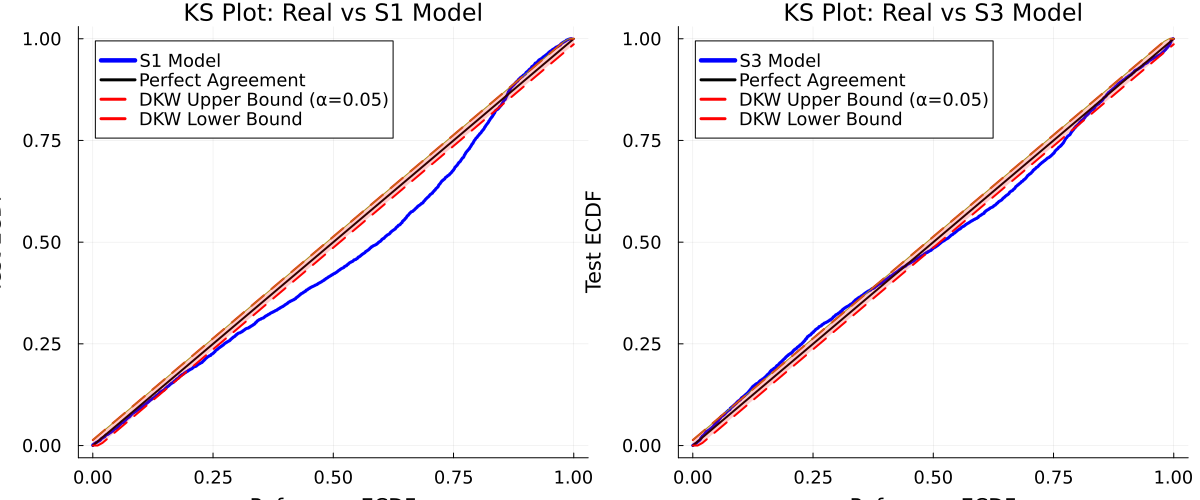

KS statistic (Real vs S1): 0.09659280500521383
KS statistic (Real vs S3): 0.03852294056308647
S1 within DKW bounds (α=0.05): false
S3 within DKW bounds (α=0.05): false


"\\Users\\ryansenne\\Desktop\\ks_plots.svg"

In [34]:
using Plots, StatsBase, Statistics

# Your existing data loading code
mouse_df, rts, outcomes, dates = load_mouse_data(df, mouse_names[1])
results_by_date = build_results_by_date(rts, outcomes, dates)
seq_ends = cumsum([length(seq) for seq in results_by_date])
all_results = reduce(vcat, results_by_date)

real_data = [result.rt for result in all_results]
s3_data = [result.rt for result in data3]
s1_data = [result.rt for result in data1]

# Create ECDFs
ecdf_real = StatsBase.ecdf(real_data)
ecdf_s3 = StatsBase.ecdf(s3_data)
ecdf_s1 = StatsBase.ecdf(s1_data)

# Function to create KS plot with DKW bounds
function ks_plot_with_bounds(ecdf_reference, ecdf_test, data_test; 
                           alpha=0.05, label_test="Test Data", 
                           title_str="KS Plot with DKW Bounds")
    
    n = length(data_test)
    
    # DKW inequality: epsilon = sqrt(-ln(alpha/2) / (2*n))
    epsilon = sqrt(-log(alpha/2) / (2*n))
    
    # Create evaluation points (use sorted test data for precise comparison)
    eval_points = sort(data_test)
    
    # Evaluate ECDFs at these points
    ref_values = ecdf_reference.(eval_points)
    test_values = ecdf_test.(eval_points)
    
    # Create the plot
    p = plot(ref_values, test_values, 
             seriestype=:line, 
             label=label_test,
             xlabel="Reference ECDF", 
             ylabel="Test ECDF",
             title=title_str,
             linewidth=3,
             color=:blue,
             # Font size controls
             titlefontsize=16,
             guidefontsize=14,
             tickfontsize=12,
             legendfontsize=12)
    
    # Add unity line (perfect agreement)
    plot!(p, [0, 1], [0, 1], 
          line=:solid, 
          color=:black, 
          linewidth=2,
          label="Perfect Agreement")
    
    # Add DKW bounds
    x_range = 0:0.01:1
    upper_bound = min.(x_range .+ epsilon, 1.0)
    lower_bound = max.(x_range .- epsilon, 0.0)
    
    plot!(p, x_range, upper_bound, 
          line=:dash, 
          color=:red, 
          linewidth=2,
          label="DKW Upper Bound (α=$alpha)")
    
    plot!(p, x_range, lower_bound, 
          line=:dash, 
          color=:red, 
          linewidth=2,
          label="DKW Lower Bound")
    
    # Fill the confidence band
    plot!(p, x_range, upper_bound, 
          fillrange=lower_bound, 
          fillalpha=0.2, 
          fillcolor=:red,
          label="")
    
    return p
end

# Create KS plots comparing your models to real data
p1 = ks_plot_with_bounds(ecdf_real, ecdf_s1, s1_data, 
                        label_test="S1 Model", 
                        title_str="KS Plot: Real vs S1 Model")

p2 = ks_plot_with_bounds(ecdf_real, ecdf_s3, s3_data, 
                        label_test="S3 Model", 
                        title_str="KS Plot: Real vs S3 Model")

# Display both plots
p = plot(p1, p2, layout=(1,2), size=(1200, 500))
display(p)

# Optional: Calculate actual KS statistics
function ks_statistic(ecdf1, ecdf2, data)
    eval_points = sort(data)
    max_diff = maximum(abs.(ecdf1.(eval_points) .- ecdf2.(eval_points)))
    return max_diff
end

ks_stat_s1 = ks_statistic(ecdf_real, ecdf_s1, s1_data)
ks_stat_s3 = ks_statistic(ecdf_real, ecdf_s3, s3_data)

println("KS statistic (Real vs S1): $ks_stat_s1")
println("KS statistic (Real vs S3): $ks_stat_s3")

# Check if models fall within DKW bounds
n_s1, n_s3 = length(s1_data), length(s3_data)
epsilon_s1 = sqrt(-log(0.05/2) / (2*n_s1))
epsilon_s3 = sqrt(-log(0.05/2) / (2*n_s3))

println("S1 within DKW bounds (α=0.05): $(ks_stat_s1 <= epsilon_s1)")
println("S3 within DKW bounds (α=0.05): $(ks_stat_s3 <= epsilon_s3)")

savefig(p, "/Users/ryansenne/Desktop/ks_plots.svg")

In [14]:
save("hmm_results.jld2", model_dict)

In [29]:
accuracies = Dict{String, Vector{Float64}}()
mean_rts   = Dict{String, Vector{Float64}}()

for mouse in mouse_names
    println("Processing $mouse")

    # Load mouse data
    mouse_df, rts_mouse, outcomes, dates = load_mouse_data(df, mouse)
    results_by_date = build_results_by_date(rts_mouse, outcomes, dates)
    seq_ends = cumsum([length(seq) for seq in results_by_date])
    all_results = reduce(vcat, results_by_date)

    # Get model and posterior state assignments
    model = model_dict[mouse][3]
    posteriors = forward(model, all_results; seq_ends=seq_ends)[1]
    most_likely_states = argmax.(eachcol(posteriors))

    # Initialize per-state storage
    mouse_acc = Float64[]
    mouse_rt  = Float64[]

    for state in 1:3
        idxs = findall(most_likely_states .== state)
        if isempty(idxs)
            push!(mouse_acc, NaN)
            push!(mouse_rt, NaN)
        else
            acc = sum(all_results[i].choice == 1 for i in idxs) / length(idxs)
            rt_avg = mean([all_results[i].rt for i in idxs])
            push!(mouse_acc, acc)
            push!(mouse_rt, rt_avg)
        end
    end

    accuracies[mouse] = mouse_acc
    mean_rts[mouse] = mouse_rt
end


Processing MTRAP-2
Processing FTRAP-7
Processing MABL6-9


In [33]:
using DataFrames

rows = []

for mouse in mouse_names
    for state in 1:3
        push!(rows, (
            mouse = mouse,
            state = state,
            accuracy = accuracies[mouse][state],
            mean_rt = mean_rts[mouse][state]
        ))
    end
end

df_metrics = DataFrame(rows)


Row,mouse,state,accuracy,mean_rt
,String15,Int64,Float64,Float64
1,MTRAP-2,1,0.862348,1.3087
2,MTRAP-2,2,0.65,0.406923
3,MTRAP-2,3,0.565444,0.297716
4,FTRAP-7,1,0.848,2.90656
5,FTRAP-7,2,0.755617,0.46748
6,FTRAP-7,3,0.585306,0.341956
7,MABL6-9,1,0.857143,1.27882
8,MABL6-9,2,0.713354,0.416147
9,MABL6-9,3,0.582498,0.296476


In [44]:
rt = @df df_metrics groupedbar(
    :state,
    :mean_rt,
    group = :mouse,
    bar_position = :dodge,
    xlabel = "State",
    ylabel = "Mean RT (s)",
    title = "Reaction Time by State and Mouse",
    legend = :topright
)
savefig(rt, "mean_rt_by_state.svg")

"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/notebooks/mean_rt_by_state.svg"

In [42]:
using StatsPlots

acc = @df df_metrics groupedbar(
    :state,
    :accuracy,
    group = :mouse,
    bar_position = :dodge,
    xlabel = "State",
    ylabel = "Accuracy",
    title = "Accuracy by State and Mouse",
    legend = false,
    ylim = (0, 1.0)
)
hline!([0.5], color=:black, linestyle=:dash, lw=2, label="Chance Level")

savefig(acc, "accuracy_by_state.svg")

"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/notebooks/accuracy_by_state.svg"

In [8]:
function state_dependent_histograms(true_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                    simulated_data::Tuple{Vector{DDMResult}, Vector{Int}},
                                    n_bins::Int=100)

    default(guidefontsize=16, tickfontsize=20, legendfontsize=14)

    true_results, true_states = true_data
    sim_results, sim_states = simulated_data

    n_states = maximum(vcat(true_states, sim_states))  # assume states ∈ 1:n
    all_rts = [r.rt for r in true_results] ∪ [r.rt for r in sim_results]
    min_rt, max_rt = extrema(all_rts)
    bin_edges = range(min_rt, max_rt, length=n_bins+1)
    bin_width = (max_rt - min_rt) / n_bins
    bin_centers = range(min_rt + bin_width/2, max_rt - bin_width/2, length=n_bins)

    # Utility function
    function compute_hist_heights(data::Vector{Float64})
        if isempty(data)
            return zeros(n_bins)
        end
        hist = fit(Histogram, data, bin_edges)
        normalize(hist.weights ./ bin_width, 1)
    end

    # Build plots for each state
    plots = Vector{Plots.Plot}(undef, n_states)

    for k in 1:n_states
        # Extract trial indices for state k
        true_idx = findall(x -> x == k, true_states)
        sim_idx  = findall(x -> x == k, sim_states)

        true_correct = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == 1]
        true_error   = [r.rt for (i, r) in enumerate(true_results) if i in true_idx && r.choice == -1]
        sim_correct  = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx  && r.choice == 1]
        sim_error    = [r.rt for (i, r) in enumerate(sim_results) if i in sim_idx  && r.choice == -1]

        true_correct_heights = compute_hist_heights(true_correct)
        true_error_heights   = compute_hist_heights(true_error)
        sim_correct_heights  = compute_hist_heights(sim_correct)
        sim_error_heights    = compute_hist_heights(sim_error)

        p = plot(title="State $k Response Times", xlabel="RT (s)", ylabel="Density")

        # Positive: correct
        bar!(p, bin_centers, true_correct_heights,
            label="True (Correct)", alpha=0.8, color=:blue, bar_width=bin_width)
        bar!(p, bin_centers, sim_correct_heights,
            label="Simulated (Correct)", alpha=0.8, color=:lightblue, bar_width=bin_width)

        # Negative: error
        bar!(p, bin_centers, -true_error_heights,
            label="True (Error)", alpha=0.8, color=:red, bar_width=bin_width)
        bar!(p, bin_centers, -sim_error_heights,
            label="Simulated (Error)", alpha=0.8, color=:pink, bar_width=bin_width)

        hline!(p, [0], color=:black, linestyle=:dash, label=nothing)

        # Symmetric ticks
        max_y = maximum(abs.([
            maximum(true_correct_heights), maximum(true_error_heights),
            maximum(sim_correct_heights),  maximum(sim_error_heights)
        ]))
        y_ticks = collect(range(-max_y, max_y, length=7))
        yticks!(p, y_ticks, [@sprintf("%.2f", abs(y)) for y in y_ticks])
        xlims!(0,4)

        plots[k] = p
    end

    return plot(plots..., layout=(n_states, 1), size=(800, 300 * n_states), legend=:topright)

end

state_dependent_histograms (generic function with 2 methods)

In [6]:
# Load data
mouse_df, rts, outcomes, dates = load_mouse_data(df, mouse_names[3])
results_by_date = build_results_by_date(rts, outcomes, dates)
seq_ends = cumsum([length(seq) for seq in results_by_date])
all_results = reduce(vcat, results_by_date)


sim_seq, sim_data = rand(model_dict["MABL6-9"][3], 10000)
posterior = forward(model_dict["MABL6-9"][3], all_results)
most_likely_states = [argmax(col) for col in eachcol(posterior[1])]


12125-element Vector{Int64}:
 3
 3
 3
 1
 3
 3
 3
 3
 3
 3
 ⋮
 3
 3
 3
 3
 3
 3
 3
 3
 3

In [12]:
hist = state_dependent_histograms((all_results, most_likely_states),
                          (sim_data, sim_seq), 100)
savefig(hist, "state_dependent_histograms.svg")

"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/notebooks/state_dependent_histograms.svg"

In [34]:
# Convert to DataFrame
rows = []

for (mouse, results) in aicbic_results
    for k in sort(collect(keys(results)))
        aic = results[k].aic
        bic = results[k].bic
        push!(rows, (mouse=mouse, n_states=k, AIC=aic, BIC=bic))
    end
end

df_metrics = DataFrame(rows)

# Compute grouped summaries
grouped_aic = combine(groupby(df_metrics, :n_states), 
    :AIC => mean => :mean_AIC,
    :AIC => (x -> std(x) / sqrt(length(x))) => :sem_AIC)

grouped_bic = combine(groupby(df_metrics, :n_states),
    :BIC => mean => :mean_BIC,
    :BIC => (x -> std(x) / sqrt(length(x))) => :sem_BIC)

# === Plot AIC ===
p1 = @df df_metrics plot(:n_states, :AIC,
    group=:mouse,
    lw=1, alpha=0.3, color=:gray,
    xlabel="Number of States", ylabel="AIC",
    title="AIC across Models and Mice",
    legend=false)

@df grouped_aic plot!(p1, :n_states, :mean_AIC,
    ribbon=:sem_AIC,
    lw=3, color=:blue,
    label="Mean ± SEM")

# === Plot BIC ===
p2 = @df df_metrics plot(:n_states, :BIC,
    group=:mouse,
    lw=1, alpha=0.3, color=:gray,
    xlabel="Number of States", ylabel="BIC",
    title="BIC across Models and Mice",
    legend=false)

@df grouped_bic plot!(p2, :n_states, :mean_BIC,
    ribbon=:sem_BIC,
    lw=3, color=:red,
    label="Mean ± SEM")

# === Combine and display ===
metrics = plot(p1, p2, layout=(1,2), size=(1000,400))

savefig(metrics, "aic_bic_results.svg")


"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/notebooks/aic_bic_results.svg"

# Refit three state model for all mice

In [35]:
model_dict = Dict{String15, PriorHMM}()

for mouse in mouse_names
        # 1. Load and process data
        mouse_df, rts, outcomes, dates = load_mouse_data(df, mouse)
        results_by_date = build_results_by_date(rts, outcomes, dates)
        seq_ends = cumsum([length(seq) for seq in results_by_date])
        all_results = reduce(vcat, results_by_date)

        # 2. Generate and fit model
        hmm = generate_hmm(3)
        hmm_fit, _ = baum_welch(hmm, all_results; seq_ends=seq_ends)

        # Save models
        model_dict[mouse] = hmm_fit
        println("Model for $mouse saved.")
end

Model for MTRAP-2 saved.
Model for FTRAP-7 saved.
Model for MABL6-9 saved.


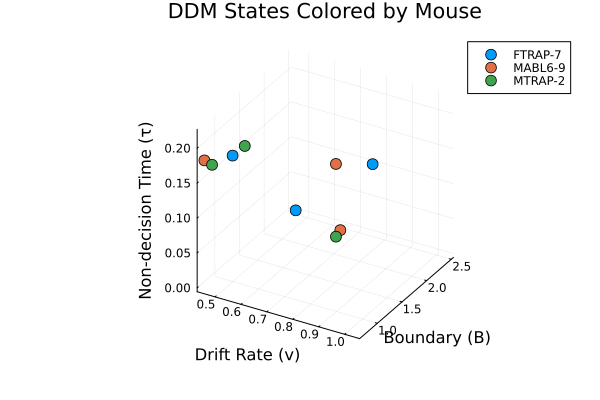

"/projectnb/depaqlab/rsenne/hmmddm/DriftDiffusionModels.jl/notebooks/ddm_states_3d.svg"

In [57]:
n_mice = length(mouse_names)
params = Matrix{Float64}(undef, 3 * n_mice, 3)
mouse_ids = String[]

row_idx = 1
for mouse in mouse_names
    model = model_dict[mouse]
    for i in 1:3
        params[row_idx, :] = [model.dists[i].v, model.dists[i].B, model.dists[i].τ]
        push!(mouse_ids, mouse)
        row_idx += 1
    end
end

p = scatter3d(
    params[:, 1],  # drift rate
    params[:, 2],  # boundary
    params[:, 3],  # non-decision time
    group=mouse_ids,            # color by mouse name
    xlabel="Drift Rate (v)",
    ylabel="Boundary (B)",
    zlabel="Non-decision Time (τ)",
    title="DDM States Colored by Mouse",
    markersize=6,
    legend=:topright
)
display(p)

savefig(p, "ddm_states_3d.svg")